In [161]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 525.1 kB/s eta 0:00:25
      --------------------------------------- 0.3/12.8 MB 1.9 MB/s eta 0:00:07
     --- ------------------------------------ 1.2/12.8 MB 6.4 MB/s eta 0:00:02
     ---------- ----------------------------- 3.2/12.8 MB 13.7 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 23.6 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.8 MB 65.6 MB/s eta 0:00:01
     --------------------------------------  12.8/12.8 MB 93.0 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 65.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [221]:
import pandas as pd
import numpy as np
import en_core_web_sm
import spacy
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [163]:
data = pd.read_csv("./sample-data.csv")
data.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


### Preprocessing

In [164]:
import re
CLEANHTML = re.compile('<.*?>')
CLEANSP = re.compile('\s{2,}')

data['text_clean'] = data['description'].apply(lambda x: re.sub(CLEANHTML, " ", x))
data['text_clean'] = data['text_clean'].apply(lambda x: ''.join(ch for ch in x if ch.isalpha() or ch==" "))
data['text_clean'] = data['text_clean'].fillna('').apply(lambda x: x.lower())
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub(CLEANSP, " ", x))
data

,id,description,text_clean
0,1,Active classic boxers - There's a reason why o...,active classic boxers theres a reason why our ...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable nofl...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...
...,...,...,...
495,496,Cap 2 bottoms - Cut loose from the maddening c...,cap bottoms cut loose from the maddening crowd...
496,497,Cap 2 crew - This crew takes the edge off fick...,cap crew this crew takes the edge off fickle w...
497,498,All-time shell - No need to use that morning T...,alltime shell no need to use that morning time...
498,499,All-wear cargo shorts - All-Wear Cargo Shorts ...,allwear cargo shorts allwear cargo shorts bask...


In [165]:
nlp = en_core_web_sm.load()

from spacy.lang.en.stop_words import STOP_WORDS

data["text_token"] = data["text_clean"].apply(lambda x: [token.lemma_ for token in nlp(x) if token.text not in STOP_WORDS])
data.head()

,id,description,text_clean,text_token
0,1,Active classic boxers - There's a reason why o...,active classic boxers theres a reason why our ...,"[active, classic, boxer, s, reason, boxer, cul..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable nofl...,"[active, sport, brief, superbreathable, nofly,..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a..."


In [166]:
detokenized_doc = []
for words in data["text_token"]:
    t = ' '.join(words)
    detokenized_doc.append(t)

data['nlp_ready'] = detokenized_doc
data.head()

,id,description,text_clean,text_token,nlp_ready
0,1,Active classic boxers - There's a reason why o...,active classic boxers theres a reason why our ...,"[active, classic, boxer, s, reason, boxer, cul...",active classic boxer s reason boxer cult favor...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning up glory re...,"[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...
2,3,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable nofl...,"[active, sport, brief, superbreathable, nofly,...",active sport brief superbreathable nofly brief...
3,4,"Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin in climb ice switch to...,"[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...
4,5,"Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt on high ridges steep ice and a...,"[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...


### Checking results of NLP

In [167]:
all_words = []
[all_words := all_words + doc for doc in data['text_token']]
len(all_words)

50517

In [168]:
df = pd.DataFrame(all_words)
word_list = df[0].value_counts().reset_index()
word_list.head(20)

,0,count
0,oz,1146
1,fabric,924
2,recycle,903
3,pocket,825
4,recyclable,704
5,polyester,689
6,thread,686
7,common,684
8,program,683
9,detail,563


### DBSCAN on TF-IDF matrix

In [169]:
# TF-IDF vector
vectorizer = TfidfVectorizer(smooth_idf=True)
X = vectorizer.fit_transform(data['nlp_ready'])
X

<500x4234 sparse matrix of type '<class 'numpy.float64'>'
	with 33504 stored elements in Compressed Sparse Row format>

In [177]:
from sklearn.cluster import DBSCAN

# this works but it's using euclidian distance so not what we want a priori
# db = DBSCAN(eps=1.2, min_samples=4)

db = DBSCAN(eps=0.7, min_samples=5, metric='cosine')
db.fit(X)
# set(db.labels_)
data['cluster'] = db.labels_
print(len(set(db.labels_)), "clusters found")
data['cluster'].value_counts()

18 clusters found


cluster
 1     144
-1      97
 4      56
 0      50
 9      24
 2      22
 7      19
 13     16
 14     12
 3       9
 5       8
 11      8
 6       8
 12      7
 8       6
 15      5
 10      5
 16      4
Name: count, dtype: int64

### Word clouds

In [171]:
# creating our array of wordclouds

from PIL import Image
import wordcloud

# nf_mask = np.array(Image.open("./north_face.jpg"))

n = len(set(db.labels_))
clouds = []

for i in range(n-1):    # we don't display the outliers so we only display n-1 clouds
    wd = wordcloud.WordCloud()
#    wd = wordcloud.WordCloud(background_color="black", contour_width=5, contour_color='white', mask = nf_mask)
    cur_df = data[data.cluster == i]['nlp_ready']
    clouds.append(wd.generate(" ".join([doc for doc in cur_df])))


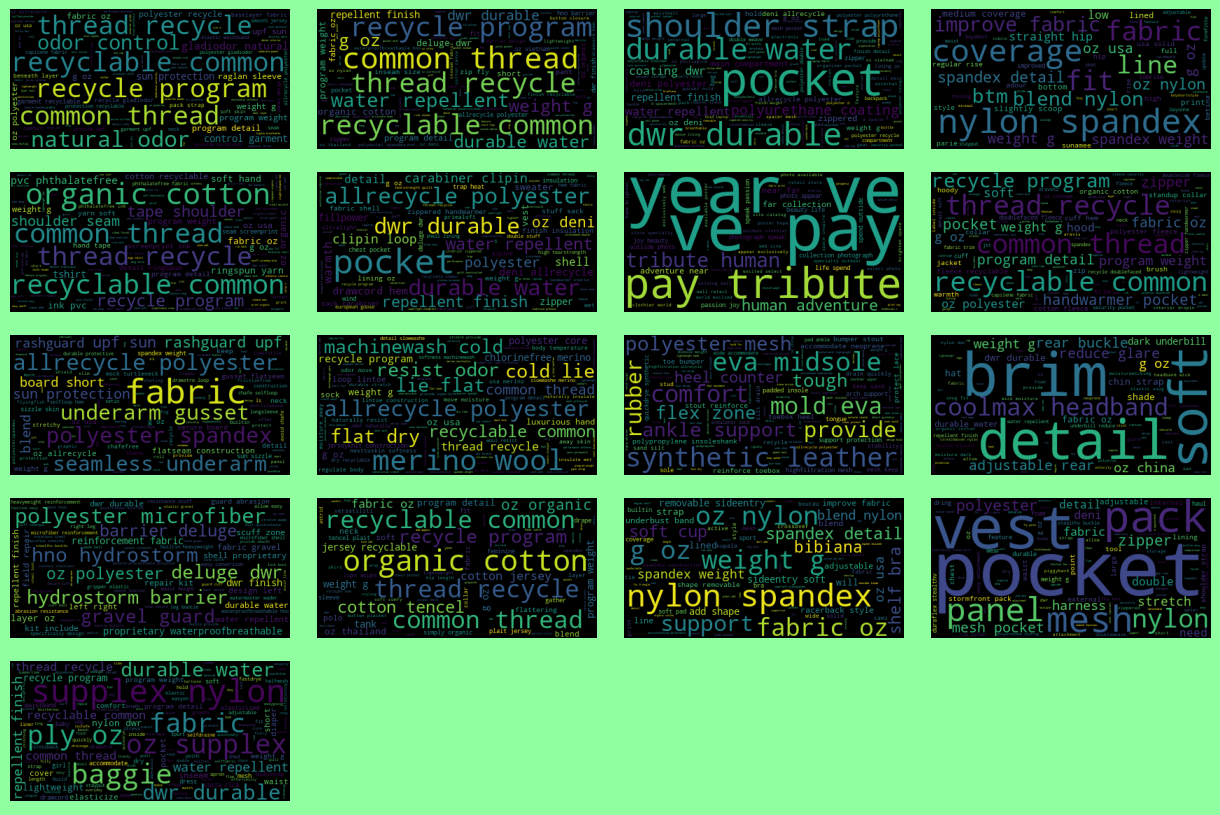

In [172]:
import matplotlib.pyplot as plt

nb_col = 4
nb_row = int(n/nb_col) + 1

f, _ax = plt.subplots(ncols=nb_col, nrows=nb_row, figsize=(15,10))
ax = _ax.flatten()
plt.setp(ax, xticks=[], yticks=[], frame_on=False)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.1)
f.patch.set_facecolor('xkcd:mint green')

for i in range(n-1):
    ax[i].imshow(clouds[i])

plt.show()

In [212]:
idx = data[data.id==12].index
cluster = data.iloc[*idx]['cluster']
cluster
products = set(data[data.cluster == cluster]['id'])
print(len(products), "produits trouvés dans le cluster", cluster)
products.remove(12)
from numpy.random import choice
import numpy as np
result = choice(np.array(list(products)), size=5, replace=False)
result

144 produits trouvés dans le cluster 1


array([ 33, 500, 454, 325, 143])

### Find similar items

In [214]:
from numpy.random import choice

def find_similar_items(df_, id_):
    idx = df_[df_.id==id_].index
    cluster = df_.iloc[*idx]['cluster']
    products = set(df_[df_.cluster == cluster]['id'])
    products.remove(id_)                                    # we don't want to recommend the original item itself!
    result = choice(np.array(list(products)), size=5, replace=False)

    return result

In [219]:
idx = int(input("Donnez le numéro de l'item pour lequel vous souhaitez des recommandations :"))
res = find_similar_items(data, idx)

for i in range(5):
    print("Nous vous recommandons :", data.iloc[res[i]]['description'].split("-")[0])

Nous vous recommandons : Ulw hiking crew socks 
Nous vous recommandons : Ascensionist jkt 
Nous vous recommandons : L/s el ray shirt 
Nous vous recommandons : Guidewater shirt 
Nous vous recommandons : Sleeveless a/c shirt 


### Topic Modeling

In [224]:
nb_topics = 10

svd_model = TruncatedSVD(n_components=nb_topics, algorithm='randomized', n_iter=100)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_{}".format(i+1) for i in range(nb_topics)], index = data.index)
topic_encoded_df["text"] = data['nlp_ready'].values
topic_encoded_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,text
0,0.258834,-0.039951,0.146510,-0.122381,-0.111193,-0.008880,-0.091716,-0.021254,-0.128885,-0.002405,active classic boxer s reason boxer cult favor...
1,0.244647,-0.047276,0.075513,-0.112817,-0.021718,0.090983,0.016434,-0.037813,-0.081351,-0.025310,active sport boxer brief skin glory require mo...
2,0.240244,-0.052720,0.089614,-0.059069,-0.027276,0.092875,0.120304,-0.006541,-0.064489,-0.028093,active sport brief superbreathable nofly brief...
3,0.361190,-0.231165,-0.085906,0.114619,0.015236,0.000554,-0.092734,-0.063992,-0.019869,0.016410,alpine guide pant skin climb ice switch rock t...
4,0.367154,-0.264390,-0.010594,0.242444,-0.047685,-0.047655,0.027128,0.020703,0.048837,0.036985,alpine wind jkt high ridge steep ice alpine ja...
...,...,...,...,...,...,...,...,...,...,...,...
495,0.334329,-0.076000,0.349923,-0.126746,-0.271036,-0.070559,-0.163570,-0.104059,-0.326968,-0.049246,cap bottom cut loose madden crowd search undon...
496,0.344787,-0.071595,0.451645,-0.045338,-0.308688,-0.075294,-0.072322,0.026325,-0.241687,-0.048236,cap crew crew take edge fickle weather clearin...
497,0.312288,-0.221432,-0.033389,0.246500,-0.016414,-0.224261,0.056673,-0.145071,0.077535,0.025057,alltime shell need use morning time umbrella a...
498,0.322223,0.066524,-0.179083,-0.275571,0.081150,-0.111892,-0.177633,0.080717,-0.014034,-0.006276,allwear cargo short allwear cargo short bask g...


In [225]:
topic_encoded_df["class_pred"] = [np.argmax(doc) for doc in lsa]
topic_encoded_df["class_pred"].value_counts()

class_pred
0    289
1     61
6     37
2     37
7     28
3     13
8     11
4     10
9      8
5      6
Name: count, dtype: int64

In [227]:
# creating our array of wordclouds

from PIL import Image
import wordcloud

# nf_mask = np.array(Image.open("./north_face.jpg"))

n = nb_topics
clouds = []

for i in range(n):
    wd = wordcloud.WordCloud()
#    wd = wordcloud.WordCloud(background_color="black", contour_width=5, contour_color='white', mask = nf_mask)
    cur_df = topic_encoded_df[topic_encoded_df.class_pred == i]['text']
    clouds.append(wd.generate(" ".join([doc for doc in cur_df])))


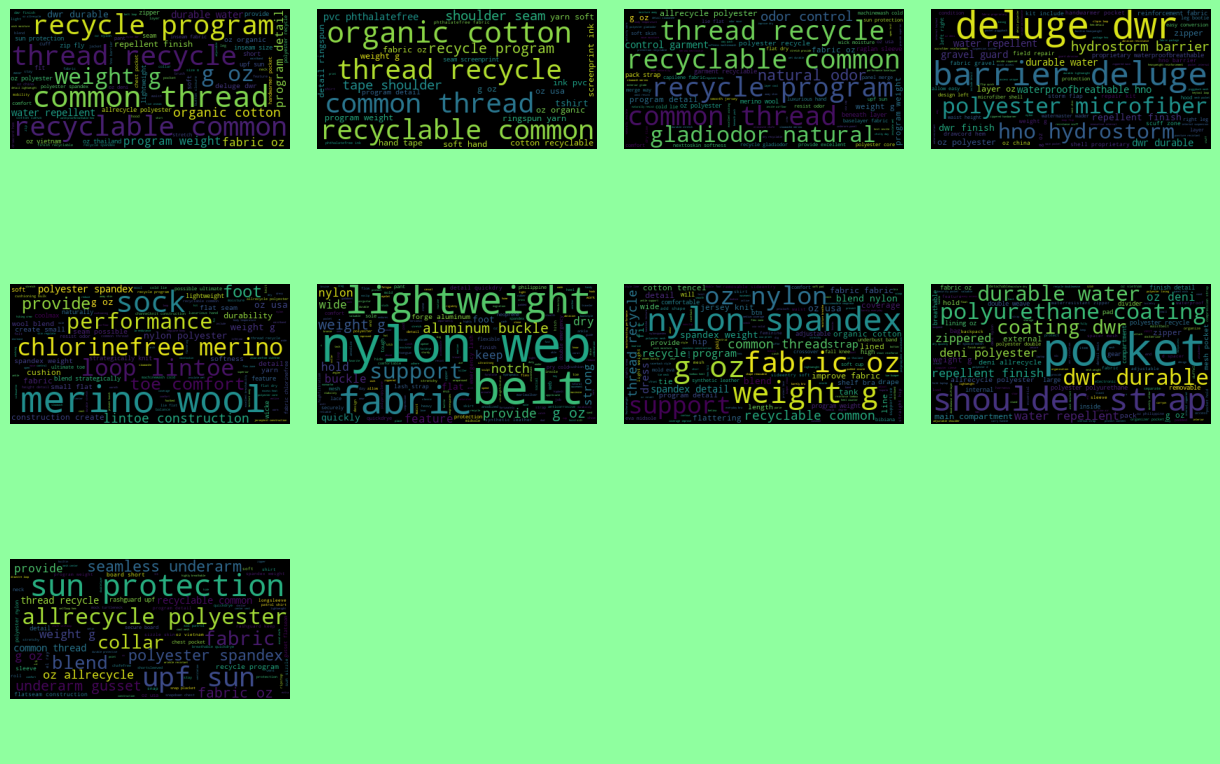

In [228]:
import matplotlib.pyplot as plt

nb_col = 4
nb_row = int(n/nb_col) + 1

f, _ax = plt.subplots(ncols=nb_col, nrows=nb_row, figsize=(15,10))
ax = _ax.flatten()
plt.setp(ax, xticks=[], yticks=[], frame_on=False)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.1)
f.patch.set_facecolor('xkcd:mint green')

for i in range(n-1):
    ax[i].imshow(clouds[i])

plt.show()